# Trial 2 Undergraduate Thesis
Goal :
- Create XGBoost and Linear Regresion Model
- Get insights from the datas
- Get the best blanket configuration

Name : Husni Naufal Zuhdi (413821)

## Regression exercise with XGBoost

In [1]:
# Basic Numerical Packages
import numpy as np
import pandas as pd
import csv as csv
import os

# Ploting Packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# XGBoost and Machine Learning related Packages
import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

In [2]:
# Set Cloud Storage Service Account
from google.cloud import storage
client = storage.Client.from_service_account_json(
    'key.json', project='iter-tritium-breeding-xgboost'
)

In [3]:
# Set variables of result file
enrich_lis = [0.1, 0.3, 0.5, 0.7, 0.9]
mod_ratios = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
neutron_multis = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
bucket = client.bucket("iter-tritium-breeding-xgboost-bucket") # Your bucket name
result_uri = "v2/results/" # Result.json files uri

# Download all result.json file in Cloud Storage Bucket
for enrich_li in enrich_lis:
    for mod_ratio in mod_ratios:
        for neutron_multi in neutron_multis:
            try:
                print("Downloading : " + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob = bucket.blob(result_uri + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob.download_to_filename("result/" + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
            except Exception:
                pass

In [2]:
# Read folder contain simulation results
path = "/home/husninaufalz/iter-tritium-breeding-xgboost/jupyter-notebooks/2-data-analysis/result"
results = os.listdir(path=path)
results.sort()

In [3]:
# Read data in each folder
data = []
for result in results:
    # Find enrichment feature
    folder_path = path + str(result)
    folder_list = result.split('-')
    folder_list = folder_list[0:3]
    
    # Read tbr and std dev data
    try:
        json_result = pd.read_json(path + "/" + result)
        json_result = json_result["blanket_fluid_mat_(n,Xt)"]["events per source particle"]
        data.append([folder_list[0], folder_list[1], folder_list[2], json_result['result'], json_result['std. dev.']])
    except Exception:
        pass

# Build dataframe from simulation data
df = pd.DataFrame(data, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier', 'Tbr_OpenMC', 'Stddev'])

# Convert all dataframe type from string into float
df.Li6_enrichment = df.Li6_enrichment.astype(float)
df.Moderator_ratio = df.Moderator_ratio.astype(float)
df.Neutron_multiplier = df.Neutron_multiplier.astype(float)

[Text(0.5, 0, 'Neutron Multiplier (%)')]

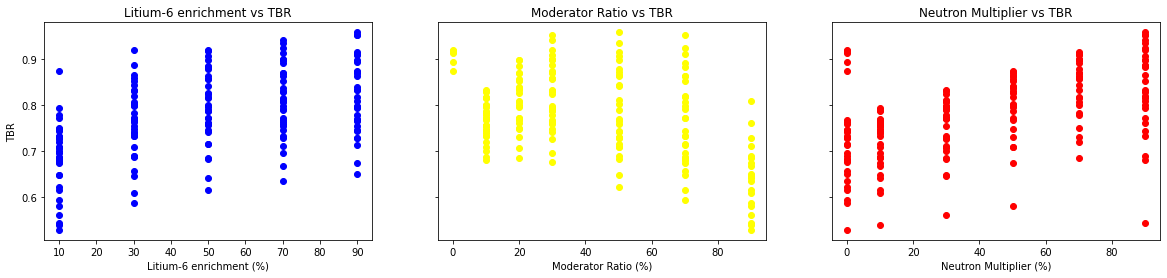

In [4]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df.Li6_enrichment*100, df.Tbr_OpenMC, c = "blue", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df.Moderator_ratio*100, df.Tbr_OpenMC, c = "yellow", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df.Neutron_multiplier*100, df.Tbr_OpenMC, c = "red", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

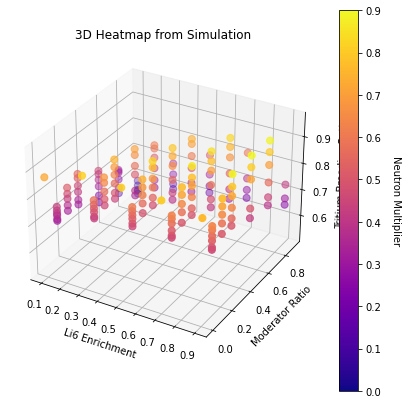

In [5]:
# Read the dataset
x = df["Li6_enrichment"].tolist()
y = df["Moderator_ratio"].tolist()
z = df["Tbr_OpenMC"].tolist()

colo = df["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

In [6]:
# See the best blanket design
df.sort_values(by=['Tbr_OpenMC'], ascending=False).head(10)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_OpenMC,Stddev
159,0.9,0.5,0.9,0.958246,0.003402
154,0.9,0.3,0.9,0.953112,0.003717
165,0.9,0.7,0.9,0.952604,0.002963
120,0.7,0.3,0.9,0.941811,0.003359
126,0.7,0.5,0.9,0.934320,0.003482
132,0.7,0.7,0.9,0.924071,0.003399
86,0.5,0.3,0.9,0.919907,0.003664
35,0.3,0.0,0.0,0.919639,0.002549
69,0.5,0.0,0.0,0.917711,0.003232
158,0.9,0.5,0.7,0.916174,0.003201


In [7]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.3, random_state=42)

In [8]:
# Load data into DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
# First hyperparameters
params = {
    # Parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'mae',
}

In [10]:
# First Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:0.24205
[1]	Test-mae:0.21869
[2]	Test-mae:0.19781
[3]	Test-mae:0.17875
[4]	Test-mae:0.16170
[5]	Test-mae:0.14717
[6]	Test-mae:0.13414
[7]	Test-mae:0.12218
[8]	Test-mae:0.11053
[9]	Test-mae:0.10061
[10]	Test-mae:0.09196
[11]	Test-mae:0.08384
[12]	Test-mae:0.07661
[13]	Test-mae:0.07057
[14]	Test-mae:0.06493
[15]	Test-mae:0.05930
[16]	Test-mae:0.05449
[17]	Test-mae:0.04989
[18]	Test-mae:0.04588
[19]	Test-mae:0.04214
[20]	Test-mae:0.03897
[21]	Test-mae:0.03581
[22]	Test-mae:0.03327
[23]	Test-mae:0.03076
[24]	Test-mae:0.02872
[25]	Test-mae:0.02673
[26]	Test-mae:0.02519
[27]	Test-mae:0.02349
[28]	Test-mae:0.02213
[29]	Test-mae:0.02082
[30]	Test-mae:0.01988
[31]	Test-mae:0.01866
[32]	Test-mae:0.01767
[33]	Test-mae:0.01687
[34]	Test-mae:0.01600
[35]	Test-mae:0.01521
[36]	Test-mae:0.01460
[37]	Test-mae:0.01400
[38]	Test-mae:0.01354
[39]	Test-mae:0.01306
[40]	Test-mae:0.01265
[41]	Test-mae:0.01230
[42]	Test-mae:0.01202
[43]	Test-mae:0.01171
[44]	Test-mae:0.01133
[45]	Test-mae:0.0109

In [11]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 0.01 with 102 rounds


In [12]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.250889,0.001674,0.251066,0.007543
1,0.226745,0.001512,0.227058,0.007798
2,0.205053,0.001423,0.205642,0.007777
3,0.185343,0.001276,0.185919,0.007908
4,0.167614,0.001145,0.168119,0.007939
...,...,...,...,...
103,0.001909,0.000261,0.009788,0.001565
104,0.001898,0.000257,0.009790,0.001563
105,0.001890,0.000255,0.009788,0.001565
106,0.001882,0.000254,0.009787,0.001567


In [13]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,11)
    for min_child_weight in range(1,11)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
	MAE 0.0203266 for 873 rounds
CV with max_depth=1, min_child_weight=2
	MAE 0.0203266 for 873 rounds
CV with max_depth=1, min_child_weight=3
	MAE 0.0257978 for 835 rounds
CV with max_depth=1, min_child_weight=4
	MAE 0.0288634 for 709 rounds
CV with max_depth=1, min_child_weight=5
	MAE 0.0288634 for 709 rounds
CV with max_depth=1, min_child_weight=6
	MAE 0.0288634 for 709 rounds
CV with max_depth=1, min_child_weight=7
	MAE 0.0288634 for 709 rounds
CV with max_depth=1, min_child_weight=8
	MAE 0.0288634 for 709 rounds
CV with max_depth=1, min_child_weight=9
	MAE 0.030681000000000003 for 412 rounds
CV with max_depth=1, min_child_weight=10
	MAE 0.035576199999999995 for 369 rounds
CV with max_depth=2, min_child_weight=1
	MAE 0.0095018 for 279 rounds
CV with max_depth=2, min_child_weight=2
	MAE 0.009977000000000001 for 296 rounds
CV with max_depth=2, min_child_weight=3
	MAE 0.0169226 for 183 rounds
CV with max_depth=2, min_child_weight=4
	MAE 0.017286600

In [14]:
# Update first and second parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [15]:
gridsearch_params = [
    (subsample, colsample, gamma)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
    for gamma in [i/10. for i in range(0,6)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample, gamma in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}, gamma={}".format(
        subsample,
        colsample,
        gamma))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    params['gamma'] = gamma
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample,gamma)
print("Best params: {}, {}, {}, MAE: {}".format(best_params[0], best_params[1], best_params[2], min_mae))

CV with subsample=1.0, colsample=1.0, gamma=0.5
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.4
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.3
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.2
	MAE 0.0677678 for 37 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.1
	MAE 0.0559302 for 37 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.0
	MAE 0.008135400000000001 for 154 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.5
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.4
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.3
	MAE 0.0680628 for 36 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.2
	MAE 0.067145 for 39 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.1
	MAE 0.0558264 for 39 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.0
	MAE 0.0105018 for 231 rounds
CV with subsample=1.0, colsample=0.8, gamma=0.5
	MAE 0.0680628 f

In [16]:
# Update third and fourth parameters
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]
params['gamma'] = best_params[2]

In [17]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [0, 1e-5, 1e-2, 0,1, 1, 100]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for reg_alpha in gridsearch_params:
    print("CV with reg_alpha={}".format(reg_alpha))
    # Update our parameters
    params['reg_alpha'] = reg_alpha
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = reg_alpha
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with reg_alpha=0
	MAE 0.0066914 for 241 rounds
CV with reg_alpha=1e-05
	MAE 0.006713800000000001 for 245 rounds
CV with reg_alpha=0.01
	MAE 0.007867 for 289 rounds
CV with reg_alpha=0
	MAE 0.0066914 for 241 rounds
CV with reg_alpha=1
	MAE 0.035025600000000004 for 215 rounds
CV with reg_alpha=1
	MAE 0.035025600000000004 for 215 rounds
CV with reg_alpha=100
	MAE 0.27767200000000003 for 0 rounds
Best params: 0, MAE: 0.0066914


In [18]:
# Update reg_alpha parameters
params['reg_alpha'] = best_params

In [19]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [0.01, 0.05, 0.07, 0.1, 0.3, 0.5]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=999,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
CV with eta=0.01
CPU times: user 7.11 s, sys: 91.8 ms, total: 7.2 s
Wall time: 1.81 s
	MAE 0.008331 for 998 rounds

CV with eta=0.05
CPU times: user 3.49 s, sys: 27.9 ms, total: 3.52 s
Wall time: 883 ms
	MAE 0.006762799999999999 for 472 rounds

CV with eta=0.07
CPU times: user 2.87 s, sys: 17.7 ms, total: 2.89 s
Wall time: 726 ms
	MAE 0.007197400000000001 for 393 rounds

CV with eta=0.1
CPU times: user 1.82 s, sys: 3.93 ms, total: 1.82 s
Wall time: 458 ms
	MAE 0.0066914 for 241 rounds

CV with eta=0.3
CPU times: user 1.1 s, sys: 12 ms, total: 1.11 s
Wall time: 280 ms
	MAE 0.008813999999999999 for 146 rounds

CV with eta=0.5
CPU times: user 754 ms, sys: 11.9 ms, total: 766 ms
Wall time: 193 ms
	MAE 0.0101608 for 97 rounds

Best params: 0.1, MAE: 0.0066914


In [20]:
# Update fifth parameters
params['eta'] = best_params

In [21]:
new_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:0.24196
[1]	Test-mae:0.21902
[2]	Test-mae:0.19758
[3]	Test-mae:0.17796
[4]	Test-mae:0.16175
[5]	Test-mae:0.14625
[6]	Test-mae:0.13252
[7]	Test-mae:0.12029
[8]	Test-mae:0.11031
[9]	Test-mae:0.10061
[10]	Test-mae:0.09177
[11]	Test-mae:0.08410
[12]	Test-mae:0.07654
[13]	Test-mae:0.06960
[14]	Test-mae:0.06401
[15]	Test-mae:0.05847
[16]	Test-mae:0.05344
[17]	Test-mae:0.04937
[18]	Test-mae:0.04519
[19]	Test-mae:0.04186
[20]	Test-mae:0.03891
[21]	Test-mae:0.03586
[22]	Test-mae:0.03308
[23]	Test-mae:0.03062
[24]	Test-mae:0.02845
[25]	Test-mae:0.02652
[26]	Test-mae:0.02472
[27]	Test-mae:0.02324
[28]	Test-mae:0.02162
[29]	Test-mae:0.02066
[30]	Test-mae:0.01991
[31]	Test-mae:0.01921
[32]	Test-mae:0.01824
[33]	Test-mae:0.01758
[34]	Test-mae:0.01692
[35]	Test-mae:0.01630
[36]	Test-mae:0.01560
[37]	Test-mae:0.01491
[38]	Test-mae:0.01435
[39]	Test-mae:0.01376
[40]	Test-mae:0.01333
[41]	Test-mae:0.01280
[42]	Test-mae:0.01235
[43]	Test-mae:0.01192
[44]	Test-mae:0.01161
[45]	Test-mae:0.0111

In [22]:
# Build a validation dataframe
data_val = []
enrich = [0.05*x for x in range(1,21)]
nm = [0.05*x for x in range(1,21)]
mod = [0.05*x for x in range(1,21)]
for i in enrich:
    for j in mod:
        for k in nm:
            data_val.append([i, j, k, 0, 0])
            
df_val = pd.DataFrame(data_val,
                      columns=['Li6_enrichment',
                               'Moderator_ratio',
                               'Neutron_multiplier',
                               'Tbr_XGBoost',
                               'Tbr_OpenMC'
                              ]
                     )

In [23]:
# Move TBR_OpenMC in df dataframe into d_val dataframe
for i in enrich:
    for j in mod:
        for k in nm:
            try:
                tbr_row = df.loc[(df["Li6_enrichment"] == i) & (df["Moderator_ratio"] == j) & (df["Neutron_multiplier"] == k)]
                tbr_row = tbr_row['Tbr_OpenMC']
                tbr_row = tbr_row.to_numpy()

                tbr_ml_row = df_val.loc[(df_val["Li6_enrichment"] == i) & (df_val["Moderator_ratio"] == j) & (df_val["Neutron_multiplier"] == k)]
                df_val.iloc[tbr_ml_row.index, 4] = tbr_row[0]
                print("Move TBR_OpenMC in df dataframe into d_val dataframe")
            except Exception:
                pass

Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dataframe
Move TBR_OpenMC in df dataframe into d_val dat

In [24]:
# Make predictions with best model for validation data
features_columns = ['Li6_enrichment', 'Moderator_ratio', 'Neutron_multiplier']
dval = xgb.DMatrix(df_val[features_columns])
y_pred = new_model.predict(dval)
df_val['Tbr_XGBoost'] = y_pred

In [25]:
df_val.sort_values(by=['Tbr_XGBoost'], ascending=False).head(20)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_XGBoost,Tbr_OpenMC
6176,0.80,0.45,0.85,0.956562,0.000000
6998,0.90,0.50,0.95,0.956562,0.000000
7816,1.00,0.55,0.85,0.956562,0.000000
7817,1.00,0.55,0.90,0.956562,0.000000
7818,1.00,0.55,0.95,0.956562,0.000000
7819,1.00,0.55,1.00,0.956562,0.000000
7017,0.90,0.55,0.90,0.956562,0.000000
7016,0.90,0.55,0.85,0.956562,0.000000
6179,0.80,0.45,1.00,0.956562,0.000000
7015,0.90,0.55,0.80,0.956562,0.000000


[Text(0.5, 0, 'Neutron Multiplier (%)')]

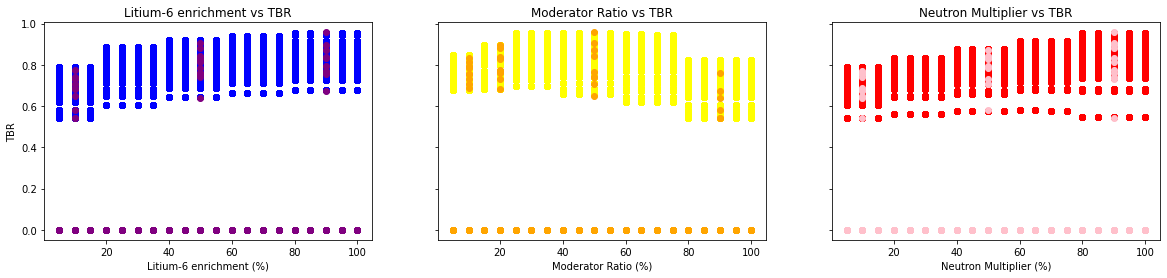

In [26]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_XGBoost, c = "blue", marker = "o")
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_OpenMC, c = "purple", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_XGBoost, c = "yellow", marker = "o")
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_OpenMC, c = "orange", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_XGBoost, c = "red", marker = "o")
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_OpenMC, c = "pink", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

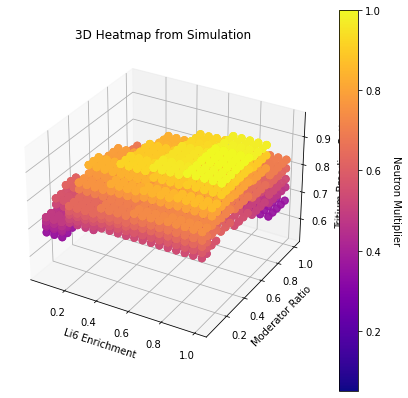

In [27]:
# Read the dataset
x = df_val["Li6_enrichment"].tolist()
y = df_val["Moderator_ratio"].tolist()
z = df_val["Tbr_XGBoost"].tolist()

colo = df_val["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

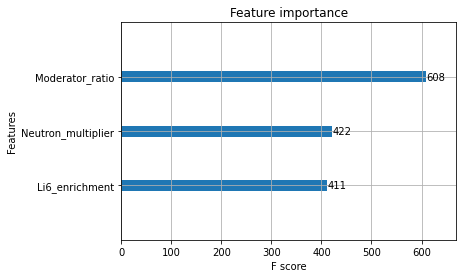

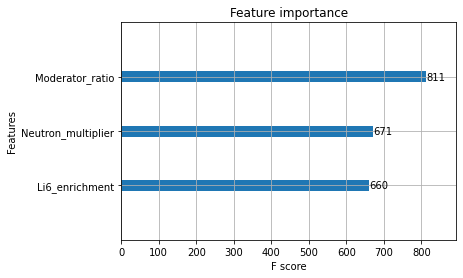

In [30]:
xgb.plot_importance(model)
xgb.plot_importance(new_model)